Connected to database successfully
Loaded 3660 movies with complete financial and theatre data
ROI ranges from -100.0% to 43051.8%

Budget tier distribution:
budget_tier
Medium ($5-25M)        1328
High ($25-75M)         1168
Blockbuster (>$75M)     605
Low (<$5M)              559
Name: count, dtype: int64

Overall correlation between theatre count and ROI: -0.018

Low (<$5M): Correlation 0.162, ROI 932.7%, Theatres 427

Medium ($5-25M): Correlation 0.227, ROI 233.0%, Theatres 1330

High ($25-75M): Correlation 0.289, ROI 153.0%, Theatres 2505

Blockbuster (>$75M): Correlation 0.355, ROI 201.0%, Theatres 3466


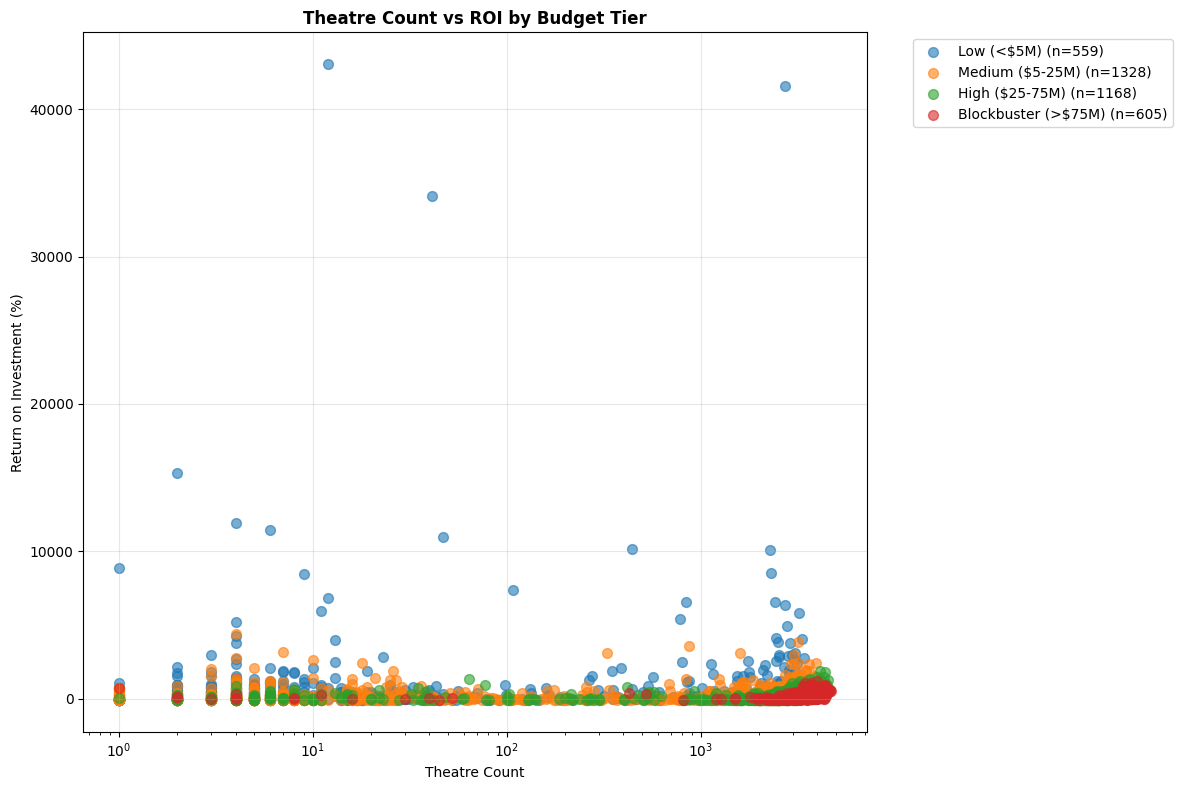


KEY INSIGHTS AND BUSINESS IMPLICATIONS
• Strongest theatre-ROI relationship: Blockbuster (>$75M) (r=0.355)
• Highest average ROI: Low (<$5M) (932.7%)
• Widest releases: Blockbuster (>$75M) (3466 theatres)

• Theatre deployment efficiency:
  Low (<$5M): 218.3 ROI points per 100 theatres
  Medium ($5-25M): 17.5 ROI points per 100 theatres
  High ($25-75M): 6.1 ROI points per 100 theatres
  Blockbuster (>$75M): 5.8 ROI points per 100 theatres

ANALYSIS COMPLETE
The analysis reveals that the effect of theatre count on ROI is highly dependent on the budget tier: 
while a wider release is increasingly correlated with higher ROI for High-Budget films, 
 the movies with the highest overall ROI are overwhelmingly Low-Budget films that achieve spectacular returns with far fewer theatres, 
 demonstrating greater volatility and efficiency. 
This suggests high market penetration is a strategy of necessity for blockbusters but not a prerequisite for the most extreme financial successes in the low-b

In [6]:
# =============================================================================
# MOVIE THEATRE COUNT vs ROI ANALYSIS
# =============================================================================
# RESEARCH QUESTION: How does theatre count (market penetration) affect return 
# on investment, and how does this relationship vary across different budget levels?
# =============================================================================

import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sqlalchemy import create_engine

# =============================================================================
# STEP 1: DATABASE CONNECTION & DATA LOADING
# =============================================================================

# The connection string defines the exact address and login credentials required to access our movie database.
engine = create_engine('postgresql://admin@localhost:5432/moviedb')
print("Connected to database successfully")

# We construct the final SQL query to get all required data fields with proper validation.
query = """
SELECT 
    m.title, m.release_year as year, m.genre_ids as genre,
    bp.production_budget, bp.worldwide_box_office, bp.theatre_count
FROM movie m
JOIN box_office_performance bp ON m.movie_id = bp.movie_id
WHERE bp.theatre_count > 0 AND bp.production_budget > 0 AND bp.worldwide_box_office > 0
"""

# The SQL query is executed, and all the results are imported into our main Pandas DataFrame.
data = pd.read_sql_query(query, engine)
print(f"Loaded {len(data)} movies with complete financial and theatre data")

# =============================================================================
# STEP 2: CALCULATE ROI AND CREATE BUDGET CATEGORIES
# =============================================================================

# Return on Investment (ROI) is the core metric for measuring a movie's financial success.
# Formula: ROI = (Revenue - Cost) / Cost * 100
data['roi'] = ((data['worldwide_box_office'] - data['production_budget']) / data['production_budget']) * 100

# Movie budgets vary drastically. We group films into four budget tiers for pattern analysis.
budget_bins = [0, 5_000_000, 25_000_000, 75_000_000, float('inf')]
budget_labels = ['Low (<$5M)', 'Medium ($5-25M)', 'High ($25-75M)', 'Blockbuster (>$75M)']
# 
data['budget_tier'] = pd.cut(data['production_budget'], bins=budget_bins, labels=budget_labels)

# Use an f-string to print the minimum and maximum ROI values, formatted to one decimal place.
print(f"ROI ranges from {data['roi'].min():.1f}% to {data['roi'].max():.1f}%")
print("\nBudget tier distribution:")
print(data['budget_tier'].value_counts())

# =============================================================================
# STEP 3: CORRELATION ANALYSIS
# =============================================================================

# Correlation measures how Theatre Count and ROI move together (-1 to +1).
overall_correlation = stats.pearsonr(data['theatre_count'], data['roi'])
print(f"\nOverall correlation between theatre count and ROI: {overall_correlation[0]:.3f}")

# Analyze each budget tier separately to reveal specific distribution strategies.
tier_results = {}
for tier in data['budget_tier'].cat.categories:
    tier_data = data[data['budget_tier'] == tier]
    
    if len(tier_data) >= 10:  # Minimum sample size for reliable statistics
        correlation = stats.pearsonr(tier_data['theatre_count'], tier_data['roi'])
        tier_results[tier] = {
            'correlation': correlation[0], 'p_value': correlation[1],
            'sample_size': len(tier_data), 'average_roi': tier_data['roi'].mean(),
            'average_theatres': tier_data['theatre_count'].mean()
        }
        
        print(f"\n{tier}: Correlation {correlation[0]:.3f}, ROI {tier_data['roi'].mean():.1f}%, "
              f"Theatres {tier_data['theatre_count'].mean():.0f}")

# =============================================================================
# STEP 4: VISUALIZATION
# =============================================================================

# A scatter plot shows Theatre Count vs ROI with different colors for each Budget Tier.
plt.figure(figsize=(12, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, tier in enumerate(data['budget_tier'].cat.categories):
    tier_data = data[data['budget_tier'] == tier]
    if len(tier_data) > 0:
        plt.scatter(tier_data['theatre_count'], tier_data['roi'], 
                   color=colors[i], label=f'{tier} (n={len(tier_data)})', alpha=0.6, s=50)

plt.xlabel('Theatre Count')
plt.ylabel('Return on Investment (%)')
plt.title('Theatre Count vs ROI by Budget Tier', fontweight='bold')
plt.xscale('log')  # Logarithmic scale prevents small releases from clustering
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# STEP 5: BUSINESS INSIGHTS
# =============================================================================

# Translate quantitative results into actionable business recommendations.
print("\n" + "="*60)
print("KEY INSIGHTS AND BUSINESS IMPLICATIONS")
print("="*60)

if tier_results:
    # Find the budget tier where theatre count is the most reliable predictor of ROI
    strongest_tier = max(tier_results.keys(), key=lambda x: abs(tier_results[x]['correlation']))
    highest_roi_tier = max(tier_results.keys(), key=lambda x: tier_results[x]['average_roi'])
    widest_release_tier = max(tier_results.keys(), key=lambda x: tier_results[x]['average_theatres'])
    
    print(f"• Strongest theatre-ROI relationship: {strongest_tier} "
          f"(r={tier_results[strongest_tier]['correlation']:.3f})")
    print(f"• Highest average ROI: {highest_roi_tier} "
          f"({tier_results[highest_roi_tier]['average_roi']:.1f}%)")
    print(f"• Widest releases: {widest_release_tier} "
          f"({tier_results[widest_release_tier]['average_theatres']:.0f} theatres)")
    
    # Calculate deployment efficiency (ROI per 100 theatres)
    print(f"\n• Theatre deployment efficiency:")
    for tier, results in tier_results.items():
        efficiency = results['average_roi'] / results['average_theatres'] * 100
        print(f"  {tier}: {efficiency:.1f} ROI points per 100 theatres")

print(f"\n" + "="*60)
print("ANALYSIS COMPLETE")
print("The analysis reveals that the effect of theatre count on ROI is highly dependent on the budget tier: \n"
      "while a wider release is increasingly correlated with higher ROI for High-Budget films, \n " \
      "the movies with the highest overall ROI are overwhelmingly Low-Budget films that achieve spectacular returns with far fewer theatres, \n " \
      "demonstrating greater volatility and efficiency. \n" \
      "This suggests high market penetration is a strategy of necessity for blockbusters but not a prerequisite for the most extreme financial successes in the low-budget space.")
print("="*60)
print(f"Analyzed {len(data)} movies across {len(tier_results)} budget tiers")